# <u>Regression Module Project: Estimating Zillow Home Value</u>

### Project Scenario:
You are a junior data scientist on the __Zillow data science team__ and recieve the following email in your inbox:

__We want to be able to predict the property tax assessed values ('taxvaluedollarcnt') of Single Family Properties that had a transaction during 2017.__

We have a model already, but we are hoping your insights can help us improve it. __I need recommendations on a way to make a better model.__ Maybe you will create a new feature out of existing ones that works better, try a non-linear regression algorithm, or try to create a different model for each county. Whatever you find that works (or doesn't work) will be useful. Given you have just joined our team, we are excited to see your outside perspective.

(One last thing, Zach lost the email that told us where these properties were located. Ugh, Zach :-/. Because property taxes are assessed at the county level, we would like to know what states and counties these are located in).

-- The Zillow Data Science Team



## Import Required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

from acquire import get_zillow
from prepare import prepare_zillow, remove_outliers

from scipy import stats
from scipy.stats import pearsonr, spearmanr
import sklearn.preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SelectKBest, f_regression, RFE, SequentialFeatureSelector

from evaluate import select_kbest_feature_engineering, rfe_feature_engineering
from evaluate import scaled_data, assessed_value_regression_plot, baseline_vs_model_regression

from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures


## Acquire prepped and split data

#### - Moving forward, train data will be used to prevent data leakage

In [2]:
train, validate, test = prepare_zillow()

Status: Acquiring data from cached csv file..


In [3]:
# Examine split integrity
print(f'\n\tTrain Shape: {train.shape}\n\n\tValidate Shape: {validate.shape}\n\n\tTest Shape: {test.shape}' )


	Train Shape: (21752, 8)

	Validate Shape: (9323, 8)

	Test Shape: (7769, 8)


## <u>Initial Data Explolatory Analysis</u>

In [4]:
train.head()

,bed_count,bath_count,square_feet,assessed_value,year_built,fips,trans_date,trans_month
52025,4.0,2.5,2273.0,632472.0,1996.0,6059.0,2017-09-14,9
44995,3.0,1.0,1087.0,220726.0,1951.0,6037.0,2017-08-09,8
5788,4.0,2.0,1901.0,378909.0,1938.0,6037.0,2017-02-10,2
5772,2.0,1.0,1200.0,46969.0,1965.0,6037.0,2017-02-10,2
11140,1.0,2.0,988.0,415256.0,1962.0,6037.0,2017-03-16,3


In [5]:
# Split trans date into month and date and remove trailing .0 from year_built

train['trans_month'] = pd.DatetimeIndex(train['trans_date']).month
train['trans_day'] = pd.DatetimeIndex(train['trans_date']).day
train['built_year'] = train['year_built'].astype('int64')
train['zip_code'] = train['fips'].astype('int64')

train = train.drop(columns = ['trans_date', 'year_built','fips'])

validate['trans_month'] = pd.DatetimeIndex(validate['trans_date']).month
validate['trans_day'] = pd.DatetimeIndex(validate['trans_date']).day
validate['built_year'] = validate['year_built'].astype('int64')
validate['zip_code'] = validate['fips'].astype('int64')

validate = validate.drop(columns = ['trans_date', 'year_built','fips'])

test['trans_month'] = pd.DatetimeIndex(test['trans_date']).month
test['trans_day'] = pd.DatetimeIndex(test['trans_date']).day
test['built_year'] = test['year_built'].astype('int64')
test['zip_code'] = test['fips'].astype('int64')

test = test.drop(columns = ['trans_date', 'year_built', 'fips'])



In [6]:
train.head()

,bed_count,bath_count,square_feet,assessed_value,trans_month,trans_day,built_year,zip_code
52025,4.0,2.5,2273.0,632472.0,9,14,1996,6059
44995,3.0,1.0,1087.0,220726.0,8,9,1951,6037
5788,4.0,2.0,1901.0,378909.0,2,10,1938,6037
5772,2.0,1.0,1200.0,46969.0,2,10,1965,6037
11140,1.0,2.0,988.0,415256.0,3,16,1962,6037


## Map locations with National Data

In [7]:
# Map fits with national data  
# (Source: https://www.nrcs.usda.gov/wps/portal/nrcs/detail/national/home/?cid=nrcs143_013697)

# Get unique locations
location = train.zip_code.unique()
location

array([6059, 6037, 6111])

### Create new columns with names of city

In [8]:
train['city'] = train.zip_code.replace({6037: 'Los Angeles', 6059:'Orange', 6111:'Ventura'})
validate['city'] = validate.zip_code.replace({6037: 'Los Angeles', 6059:'Orange', 6111:'Ventura'})
test['city'] = test.zip_code.replace({6037: 'Los Angeles', 6059:'Orange', 6111:'Ventura'})

train.head()

,bed_count,bath_count,square_feet,assessed_value,trans_month,trans_day,built_year,zip_code,city
52025,4.0,2.5,2273.0,632472.0,9,14,1996,6059,Orange
44995,3.0,1.0,1087.0,220726.0,8,9,1951,6037,Los Angeles
5788,4.0,2.0,1901.0,378909.0,2,10,1938,6037,Los Angeles
5772,2.0,1.0,1200.0,46969.0,2,10,1965,6037,Los Angeles
11140,1.0,2.0,988.0,415256.0,3,16,1962,6037,Los Angeles


In [9]:
# Describe the data

train.describe()

,bed_count,bath_count,square_feet,assessed_value,trans_month,trans_day,built_year,zip_code
count,21752.000000,21752.000000,21752.000000,21752.000000,21752.000000,21752.000000,21752.000000,21752.000000
mean,3.082935,1.944166,1514.400653,315589.601186,5.056592,16.648078,1959.363967,6048.410905
std,0.783795,0.650836,437.008695,193235.550518,2.361334,8.970359,20.573062,20.734053
min,1.000000,0.000000,501.000000,10504.000000,1.000000,1.000000,1880.000000,6037.000000
25%,3.000000,1.500000,1186.000000,149156.500000,3.000000,9.000000,1949.000000,6037.000000
50%,3.000000,2.000000,1463.000000,295292.500000,5.000000,17.000000,1957.000000,6037.000000
75%,4.000000,2.000000,1822.000000,452516.250000,7.000000,25.000000,1972.000000,6059.000000
max,6.000000,5.000000,2499.000000,799789.000000,9.000000,31.000000,2016.000000,6111.000000


In [10]:
# Get data summary information
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21752 entries, 52025 to 9317
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   bed_count       21752 non-null  float64
 1   bath_count      21752 non-null  float64
 2   square_feet     21752 non-null  float64
 3   assessed_value  21752 non-null  float64
 4   trans_month     21752 non-null  int64  
 5   trans_day       21752 non-null  int64  
 6   built_year      21752 non-null  int64  
 7   zip_code        21752 non-null  int64  
 8   city            21752 non-null  object 
dtypes: float64(4), int64(4), object(1)
memory usage: 1.7+ MB


In [11]:
# Check for null values
train.isnull().sum()

bed_count         0
bath_count        0
square_feet       0
assessed_value    0
trans_month       0
trans_day         0
built_year        0
zip_code          0
city              0
dtype: int64

In [12]:
# Any null columns?
train.columns.isnull().any()

False

In [13]:
# Value counts
train.value_counts()

bed_count  bath_count  square_feet  assessed_value  trans_month  trans_day  built_year  zip_code  city       
1.0        0.0         993.0        118738.0        4            13         1922        6037      Los Angeles    1
3.0        2.5         2039.0       480325.0        4            20         2002        6059      Orange         1
                       2046.0       729029.0        4            28         2001        6059      Orange         1
                                    723660.0        3            30         2002        6059      Orange         1
                                    545329.0        9            1          2001        6059      Orange         1
                                                                                                                ..
           2.0         1102.0       269572.0        8            30         1958        6037      Los Angeles    1
                                    65328.0         2            22         1960     

## Data Scalling

### MinMaxScaler Choosen: x


In [14]:
train.columns

Index(['bed_count', 'bath_count', 'square_feet', 'assessed_value',
       'trans_month', 'trans_day', 'built_year', 'zip_code', 'city'],
      dtype='object')

In [15]:
from datetime import datetime, date

train_scaled = train.copy()
validate_scaled = validate.copy()
test_scaled = test.copy()


# train_scaled = train_scaled.drop(columns = ['city'])
# validate_scaled = validate_scaled.drop(columns = ['city'])
# test_scaled = test_scaled.drop(columns = 'city')


train_scaled["built_year"] = pd.to_datetime(train_scaled["built_year"])
validate_scaled["built_year"] = pd.to_datetime(validate_scaled["built_year"])
test_scaled["built_year"] = pd.to_datetime(test_scaled["built_year"])


train["home_age"] = train_scaled["built_year"].apply(lambda x : (pd.datetime.now().year - x.year))
validate["home_age"] = validate_scaled["built_year"].apply(lambda x : (pd.datetime.now().year - x.year))
test["home_age"] = test_scaled["built_year"].apply(lambda x : (pd.datetime.now().year - x.year))

# train_scaled = train_scaled.drop(columns =['built_year', 'trans_day'])
# validate_scaled = validate_scaled.drop(columns =['built_year', 'trans_day'])
# test_scaled = test_scaled.drop(columns =['built_year', 'trans_day'])


In [16]:
train.head()

,bed_count,bath_count,square_feet,assessed_value,trans_month,trans_day,built_year,zip_code,city,home_age
52025,4.0,2.5,2273.0,632472.0,9,14,1996,6059,Orange,52
44995,3.0,1.0,1087.0,220726.0,8,9,1951,6037,Los Angeles,52
5788,4.0,2.0,1901.0,378909.0,2,10,1938,6037,Los Angeles,52
5772,2.0,1.0,1200.0,46969.0,2,10,1965,6037,Los Angeles,52
11140,1.0,2.0,988.0,415256.0,3,16,1962,6037,Los Angeles,52


In [17]:
train.isna().any()

bed_count         False
bath_count        False
square_feet       False
assessed_value    False
trans_month       False
trans_day         False
built_year        False
zip_code          False
city              False
home_age          False
dtype: bool

In [18]:
train.zip_code.value_counts()

6037    14599
6059     5406
6111     1747
Name: zip_code, dtype: int64

In [19]:
# 1. create the object
scaler = sklearn.preprocessing.StandardScaler()

# 2. fit the object
scaler.fit(train_scaled[['square_feet']])

# 3. use the object. Scale total_bill only
train['square_feet_scaled'] = scaler.transform(train_scaled[['square_feet']])
test['square_feet_scaled'] = scaler.transform(test_scaled[['square_feet']])
validate['square_feet_scaled'] = scaler.transform(validate_scaled[['square_feet']])



In [20]:
train['age_scaled'] = scaler.transform(train[['home_age']])
test['age_scaled'] = scaler.transform(test[['home_age']])
validate['age_scaled'] = scaler.transform(validate[['home_age']])

In [21]:
train['assessed_val_scaled'] = scaler.transform(train[['assessed_value']])
test['assessed_val_scaled'] = scaler.transform(test[['assessed_value']])
validate['assessed_val_scaled'] = scaler.transform(validate[['assessed_value']])

In [22]:
train['bed_scaled'] = scaler.transform(train[['bed_count']])
test['bed_scaled'] = scaler.transform(test[['bed_count']])
validate['bed_scaled'] = scaler.transform(validate[['bed_count']])

In [23]:
train['bath_scaled'] = scaler.transform(train[['bath_count']])
test['bath_scaled'] = scaler.transform(test[['bath_count']])
validate['bath_scaled'] = scaler.transform(validate[['bath_count']])

In [24]:
train.head()

,bed_count,bath_count,square_feet,assessed_value,trans_month,trans_day,built_year,zip_code,city,home_age,square_feet_scaled,age_scaled,assessed_val_scaled,bed_scaled,bath_scaled
52025,4.0,2.5,2273.0,632472.0,9,14,1996,6059,Orange,52,1.735931,-3.346465,1443.843361,-3.456305,-3.459738
44995,3.0,1.0,1087.0,220726.0,8,9,1951,6037,Los Angeles,52,-0.978037,-3.346465,501.629924,-3.458593,-3.463170
5788,4.0,2.0,1901.0,378909.0,2,10,1938,6037,Los Angeles,52,0.884669,-3.346465,863.605870,-3.456305,-3.460882
5772,2.0,1.0,1200.0,46969.0,2,10,1965,6037,Los Angeles,52,-0.719455,-3.346465,104.015423,-3.460882,-3.463170
11140,1.0,2.0,988.0,415256.0,3,16,1962,6037,Los Angeles,52,-1.204582,-3.346465,946.780040,-3.463170,-3.460882


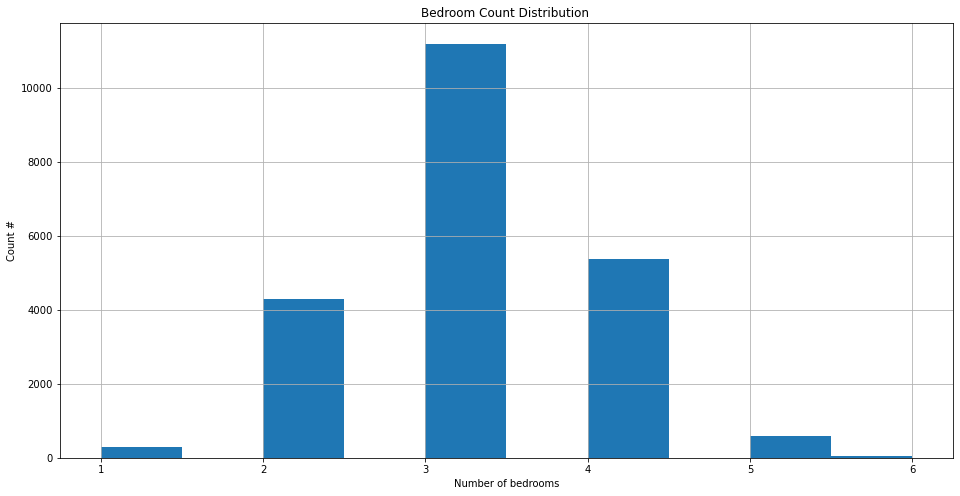

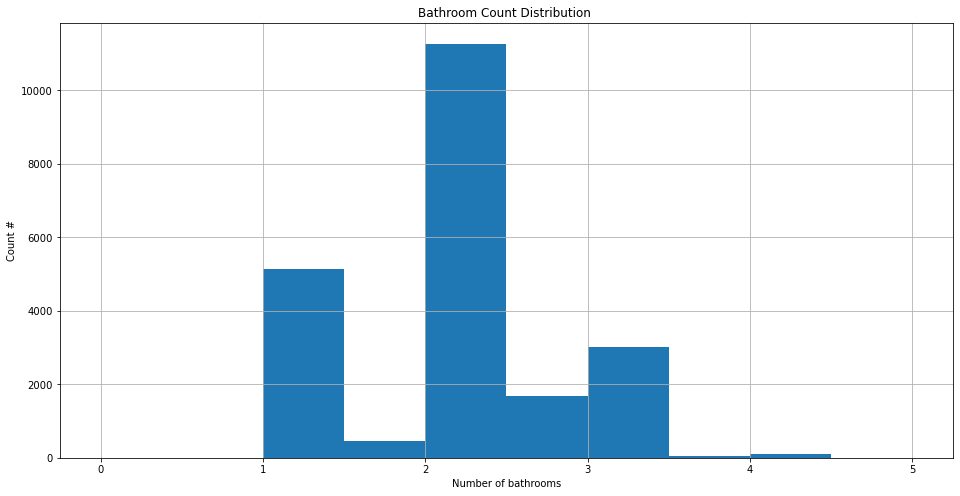

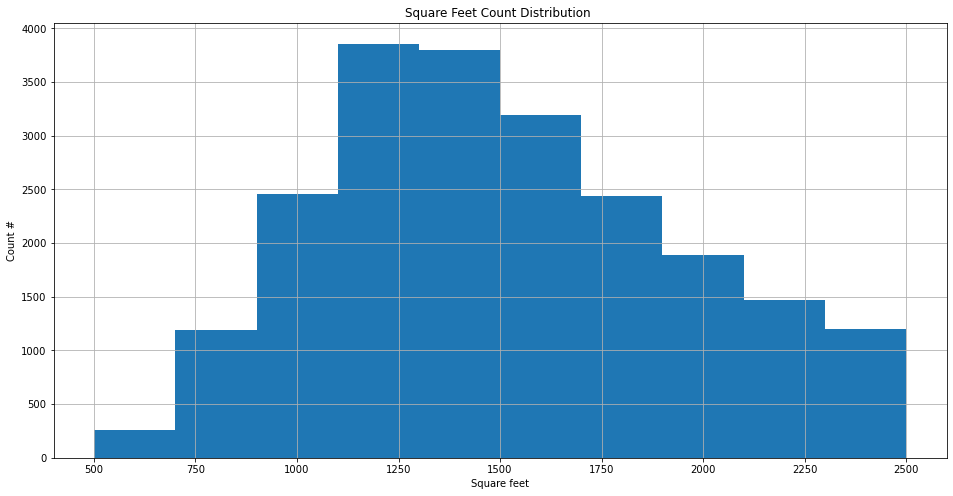

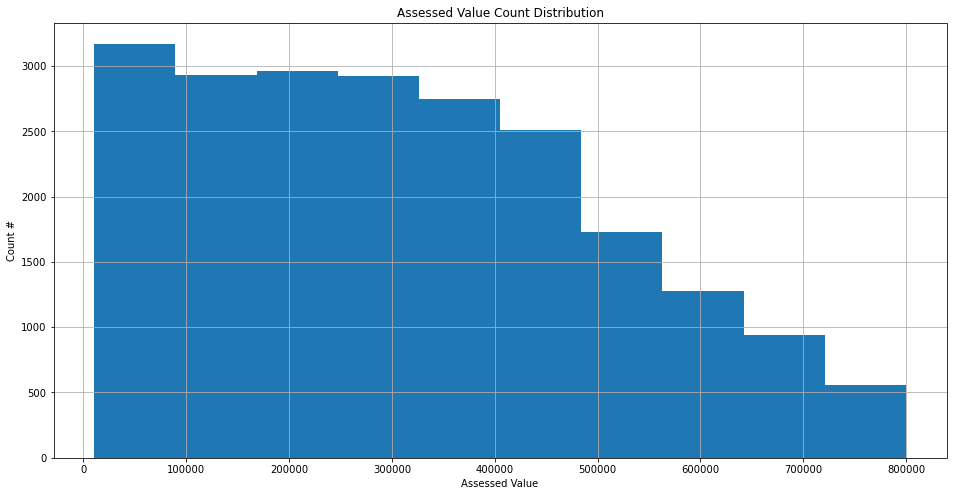

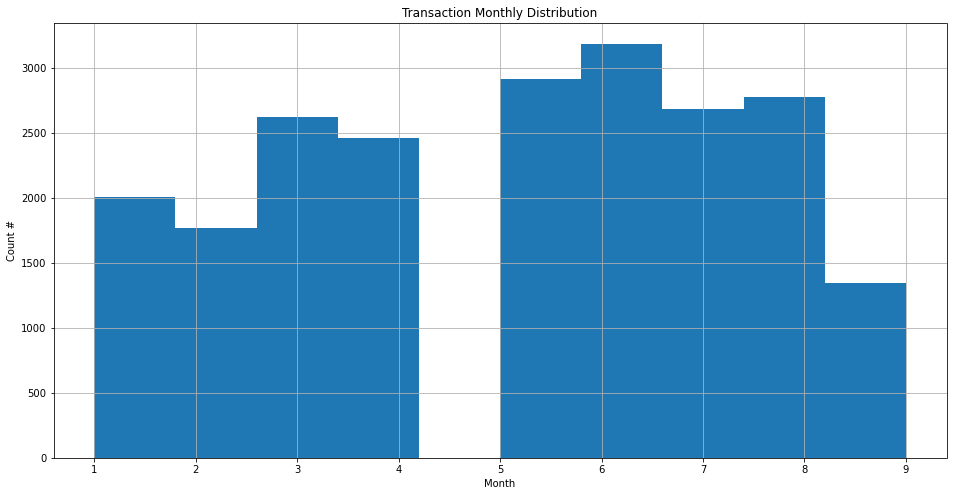

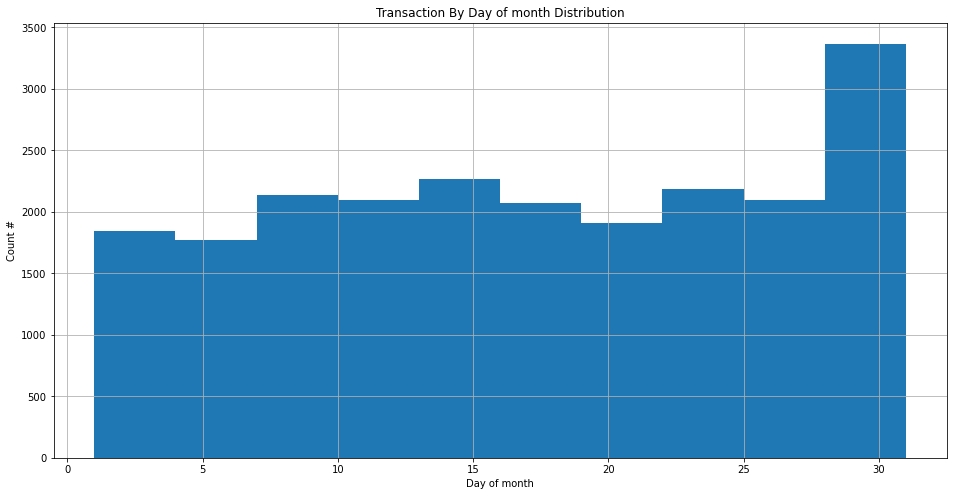

In [25]:
# Initial Visualizations
plt.figure(figsize = (16, 8))
plt.title('Bedroom Count Distribution ')
plt.ylabel('Count #')
plt.xlabel('Number of bedrooms')
train.bed_count.hist()
plt.show()
plt.figure(figsize = (16, 8))
plt.title('Bathroom Count Distribution ')
plt.ylabel('Count #')
plt.xlabel('Number of bathrooms')
train.bath_count.hist()
plt.show()
plt.figure(figsize = (16, 8))
plt.title('Square Feet Count Distribution ')
plt.ylabel('Count #')
plt.xlabel('Square feet')
train.square_feet.hist()
plt.show()
plt.figure(figsize = (16, 8))
plt.title('Assessed Value Count Distribution')
plt.ylabel('Count #')
plt.xlabel('Assessed Value')
train.assessed_value.hist()
plt.show()

plt.figure(figsize = (16, 8))
plt.title('Transaction Monthly Distribution')
plt.ylabel('Count #')
plt.xlabel('Month')
train.trans_month.hist()
plt.show()
plt.figure(figsize = (16, 8))
plt.title('Transaction By Day of month Distribution')
plt.ylabel('Count #')
plt.xlabel('Day of month')
train.trans_day.hist()
plt.show()

In [26]:
train.head()

,bed_count,bath_count,square_feet,assessed_value,trans_month,trans_day,built_year,zip_code,city,home_age,square_feet_scaled,age_scaled,assessed_val_scaled,bed_scaled,bath_scaled
52025,4.0,2.5,2273.0,632472.0,9,14,1996,6059,Orange,52,1.735931,-3.346465,1443.843361,-3.456305,-3.459738
44995,3.0,1.0,1087.0,220726.0,8,9,1951,6037,Los Angeles,52,-0.978037,-3.346465,501.629924,-3.458593,-3.463170
5788,4.0,2.0,1901.0,378909.0,2,10,1938,6037,Los Angeles,52,0.884669,-3.346465,863.605870,-3.456305,-3.460882
5772,2.0,1.0,1200.0,46969.0,2,10,1965,6037,Los Angeles,52,-0.719455,-3.346465,104.015423,-3.460882,-3.463170
11140,1.0,2.0,988.0,415256.0,3,16,1962,6037,Los Angeles,52,-1.204582,-3.346465,946.780040,-3.463170,-3.460882


## <u>Key Findings:</u>
### __NOTE:_ All homes in dataset are zillow homes of 2017
- 3 bedroom and 2 baths are the most common household classifications in 2017
- Less than 2400 square feet single familly household were the most preferable homes in 2017
- Homes built in late 1940s to early 1960s were the most transactioned homes in 2017. About 9500 homes. Followed by homes built in early 1960s to mid 1970s accounting approximately 5800, then third were homes in late 1970s to 1990s.
- Least desired/ (not transactioned) homes were those build in 1900s followed by those built between mid 1900s to about 1918s.
- Surprisingly, homes built about 1918s to late 1940s outperformed those built after about 2005
- Most transactions were average throughout the year but peaked towards the last few days of teh year. 


## Initial possible drivers for home value:

- Homes with __square feet greater than 2000__ are more likely to be bougth and sold than those below that value
- Homes with bedroom count between __3 and 4__ are more likely to generate more assessed value than other homes.
- The more the __batrooms (over 3) a home has__, the likely the rise in assessed value. 
- Homes __built after the year 2000__ are more likely to have higher assessed home value than those built before that year.
- Homes in __Los Angels__ are likely to be highly assessed due to size of city than those in Orange and Ventura


# <u>Exploration Phase:</u>

## What Arives Assessed Value?

## QUIZ 1: Is there a correlation between homes square feet and its assessed value?


##### H0 = 'There is no correlation between the homes square feet and and its variation in assessed value.'
##### H1 = 'Homes square feet is correlated to its variation in assessed value.'

> ### Visualize Square Feet VS Assessed Value

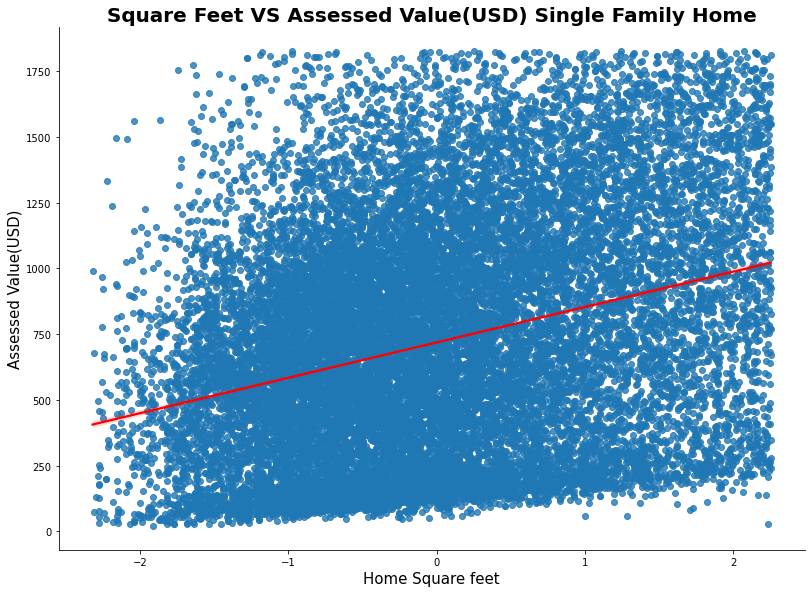

In [27]:

# Create lmplot showing regression
sns.lmplot(x = "square_feet_scaled", y = "assessed_val_scaled", data = train, 
            height = 8, aspect = 11.7/8.27, line_kws = {'color': 'red'})

plt.title('Square Feet VS Assessed Value(USD) Single Family Home', color = 'black', weight = 'bold', size = 20)
plt.xlabel('Home Square feet', size = 15, color = 'black')
plt.ylabel('Assessed Value(USD)', size = 15, color = 'black')


plt.show()




##### Calculate the 'r' and 'p' values

In [28]:
# Hypothesis
H0 = 'There is no correlation between the homes square feet and and its variation in assessed value.'
H1 = 'Homes square feet is correlated to its variation in assessed value.'

# Use a scipy stats function pearsonr to calculate the correlation coefficient and the p-value.
r, p_value = spearmanr(train.square_feet_scaled, train.assessed_val_scaled)

print('\nSPEARMANSR SQUARE FEET')

print(f'\n\t- Correlation Coefficient: {r}\n\n\t- P-value: {p_value}\n')


SPEARMANSR SQUARE FEET

	- Correlation Coefficient: 0.29267653362083484

	- P-value: 0.0



##### Test the hypothesis

In [29]:
alpha = 0.05

if p_value > alpha:
    print(f"\nFAILED TO REJECT: {H0}\n")

else:
    print(f"\nREJECT: {H0}\n")



REJECT: There is no correlation between the homes square feet and and its variation in assessed value.



## QUIZ 2: Is there a correlation between home's number of bedrooms and its assessed value?

##### H0 = 'There is no correlation between the home\'s number of bedroom and and its variation in assessed value.'
##### H1 = 'Home\'s number of bedroom is correlated to its variation in assessed value.'

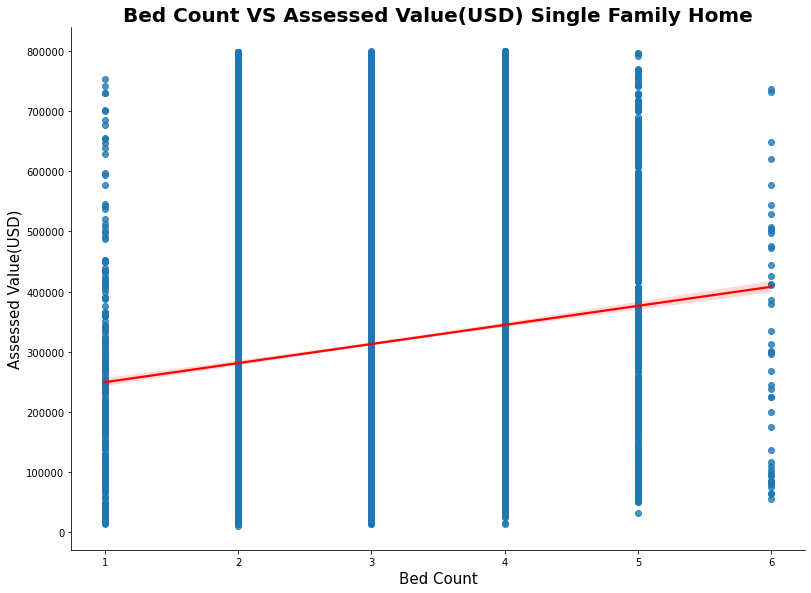

In [30]:
# Create lmplot showing regression
sns.lmplot(x="bed_count", y="assessed_value", data = train, 
            height = 8, aspect = 11.7/8.27, line_kws={'color': 'red'})

plt.title('Bed Count VS Assessed Value(USD) Single Family Home', color = 'black', weight = 'bold', size = 20)
plt.xlabel('Bed Count', size = 15, color = 'black')
plt.ylabel('Assessed Value(USD)', size = 15, color = 'black')
plt.show()




##### Calculate the 'r' and 'p' values

In [31]:
# Formulated hypothesis
H0 = 'There is no correlation between the home\'s number of bedrooms and and its variation in assessed value.'
H1 = 'Home\'s number of bedroom is correlated to its variation in assessed value.'

# Use a scipy stats function pearsonr to calculate the correlation coefficient and the p-value.
r, p_value = spearmanr(train.bed_count, train.assessed_value)

print('\nSPEARMANSR BED COUNT')

print(f'\n\t- Correlation Coefficient: {r}\n\n\t- P-value: {p_value}\n')


SPEARMANSR BED COUNT

	- Correlation Coefficient: 0.12910165956581515

	- P-value: 1.734345885982736e-81



##### Test the hypothesis

In [32]:
alpha = 0.05

if p_value > alpha:
    print(f"\nFAILED TO REJECT: {H0}\n")

else:
    print(f"\nREJECT: {H0}\n")


REJECT: There is no correlation between the home's number of bedrooms and and its variation in assessed value.



## QUIZ 3: Is there a correlation between home's number of bathrooms and its assessed value?

##### H0 = 'There is no correlation between the home\'s number of bathrooms and and its variation in assessed value.'
##### H1 = 'Home\'s number of bathrooms is correlated to its variation in assessed value.'

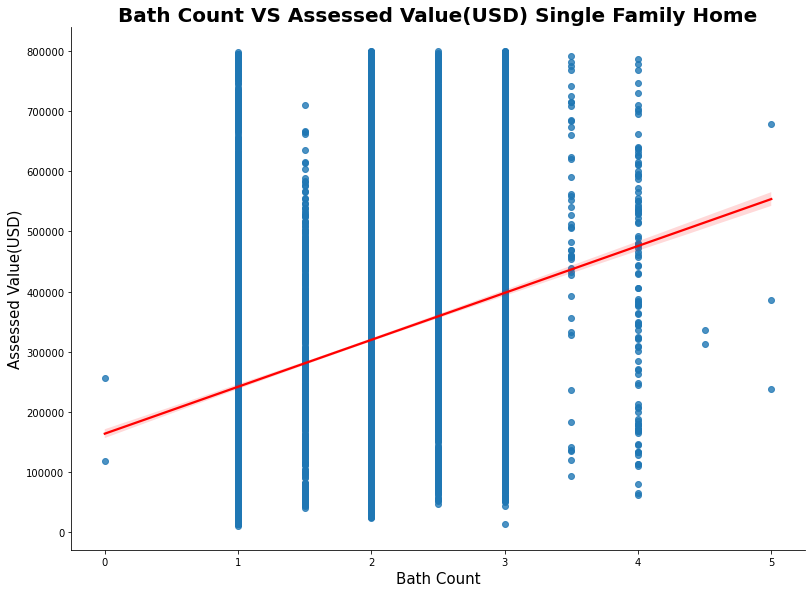

In [33]:
# Create lmplot showing regression
sns.lmplot(x="bath_count", y="assessed_value", data = train, 
            height = 8, aspect = 11.7/8.27, line_kws={'color': 'red'})

plt.title('Bath Count VS Assessed Value(USD) Single Family Home', color = 'black', weight = 'bold', size = 20)
plt.xlabel('Bath Count', size = 15, color = 'black')
plt.ylabel('Assessed Value(USD)', size = 15, color = 'black')
plt.show()




##### Calculate the 'r' and 'p' values

In [34]:
# Formulated hypothesis
H0 = 'There is no correlation between the home\'s number of bathrooms and and its variation in assessed value.'
H1 = 'Home\'s number of bathrooms is correlated to its variation in assessed value.'

# Use a scipy stats function pearsonr to calculate the correlation coefficient and the p-value.
r, p_value = spearmanr(train.bath_count, train.assessed_value)

print('\nSPEARMANSR BATH COUNT')

print(f'\n\t- Correlation Coefficient: {r}\n\n\t- P-value: {p_value}\n')


SPEARMANSR BATH COUNT

	- Correlation Coefficient: 0.27483067092625035

	- P-value: 0.0



##### Test the hypothesis

In [35]:
alpha = 0.05

if p_value > alpha:
    print(f"\nFAILED TO REJECT: {H0}\n")

else:
    print(f"\nREJECT: {H0}\n")


REJECT: There is no correlation between the home's number of bathrooms and and its variation in assessed value.



## QUIZ 4: Is there a correlation between transaction month and its assessed value?

##### H0 = 'There is no correlation between transaction month and and its variation in assessed value.'
##### H1 = 'Transaction month is correlated to its variation in assessed value.'

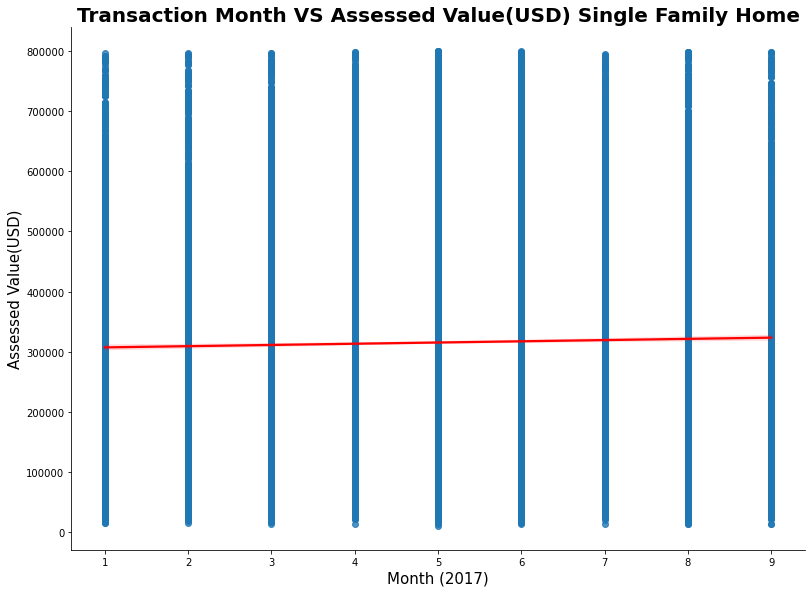

In [36]:
# Create lmplot showing regression
sns.lmplot(x="trans_month", y="assessed_value", data = train, 
            height = 8, aspect = 11.7/8.27, line_kws={'color': 'red'})

plt.title('Transaction Month VS Assessed Value(USD) Single Family Home', color = 'black', weight = 'bold', size = 20)
plt.xlabel('Month (2017)', size = 15, color = 'black')
plt.ylabel('Assessed Value(USD)', size = 15, color = 'black')
plt.show()




##### Calculate the 'r' and 'p' values

In [37]:
# Formulated hypothesis
H0 = 'There is no correlation between transaction month and and its variation in assessed value.'
H1 = 'Transaction month is correlated to its variation in assessed value.'

# Use a scipy stats function pearsonr to calculate the correlation coefficient and the p-value.

r, p_value = spearmanr(train.trans_month, train.assessed_value)

print('\nSPEARMANSR TRANSACTION MONTH')

print(f'\n\t- Correlation Coefficient: {r}\n\n\t- P-value: {p_value}\n')


SPEARMANSR TRANSACTION MONTH

	- Correlation Coefficient: 0.02425720659034913

	- P-value: 0.0003463535826348926



##### Test the hypothesis

In [38]:
alpha = 0.05

if p_value > alpha:
    print(f"\nFAILED TO REJECT: {H0}\n")

else:
    print(f"\nREJECT: {H0}\n")


REJECT: There is no correlation between transaction month and and its variation in assessed value.



## QUIZ 5: Is there a correlation between a home\'s location and its assessed value?

##### H0 = 'There is no correlation between a home\'s location and and its variation in assessed value.'
##### H1 = 'A home\s location is correlated to its variation in assessed value.'


### 6037 ==  'Los Angeles'
### 6059 == 'Orange'
### 6111 == 'Ventura'


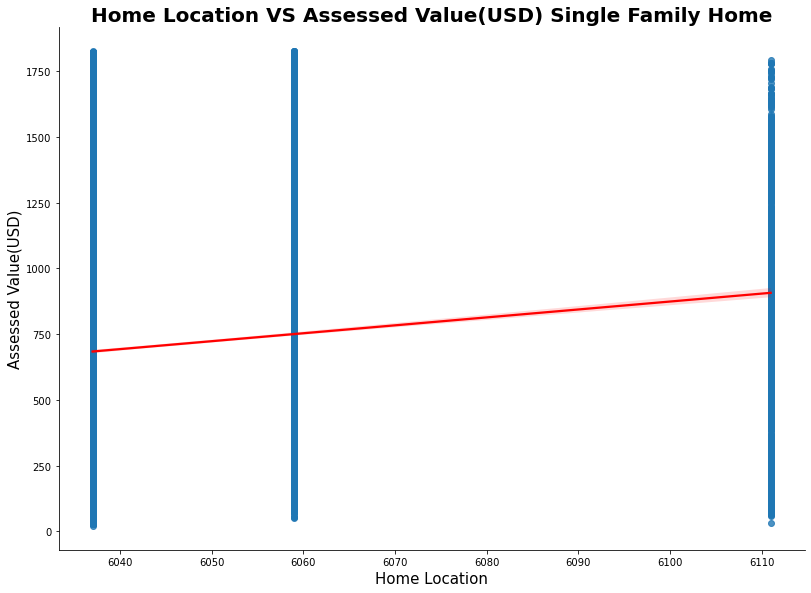

In [39]:
# Create lmplot showing regression
sns.lmplot(x="zip_code", y="assessed_val_scaled", data = train, 
            height = 8, aspect = 11.7/8.27, line_kws={'color': 'red'})

plt.title('Home Location VS Assessed Value(USD) Single Family Home', color = 'black', weight = 'bold', size = 20)
plt.xlabel('Home Location', size = 15, color = 'black')
plt.ylabel('Assessed Value(USD)', size = 15, color = 'black')
# plt.text(1, 50, f'6037 == Los Angeles')
# plt.text(1, 40, f'6059 == Orange')
# plt.text(1, 30, f'6111 == Ventura')
plt.show()


# 6037: 'Los Angeles', 6059:'Orange', 6111:'Ventura'

##### Calculate the 'r' and 'p' values

In [40]:
# Formulated hypothesis
H0 = 'There is no correlation between a home\'s location and and its variation in assessed value.'
H1 = 'A home\'s location is correlated to its variation in assessed value.'

# Use a scipy stats function pearsonr to calculate the correlation coefficient and the p-value.
r, p_value = spearmanr(train.zip_code, train.assessed_value)

print('\nSPEARMANSR LOCATION')

print(f'\n\t- Correlation Coefficient: {r}\n\n\t- P-value: {p_value}\n')


SPEARMANSR LOCATION

	- Correlation Coefficient: 0.18730644625115392

	- P-value: 6.09463640849934e-171



##### Test the hypothesis

In [41]:
alpha = 0.05

if p_value > alpha:
    print(f"\nFAILED TO REJECT: {H0}\n")

else:
    print(f"\nREJECT: {H0}\n")


REJECT: There is no correlation between a home's location and and its variation in assessed value.



## QUIZ 6: Is there a correlation between a home\'s year built and its assessed value?

##### H0 = 'There is no correlation between a home\'s year built (age) and and its variation in assessed value.'
##### H1 = 'A home\s age is correlated to its variation in assessed value.'



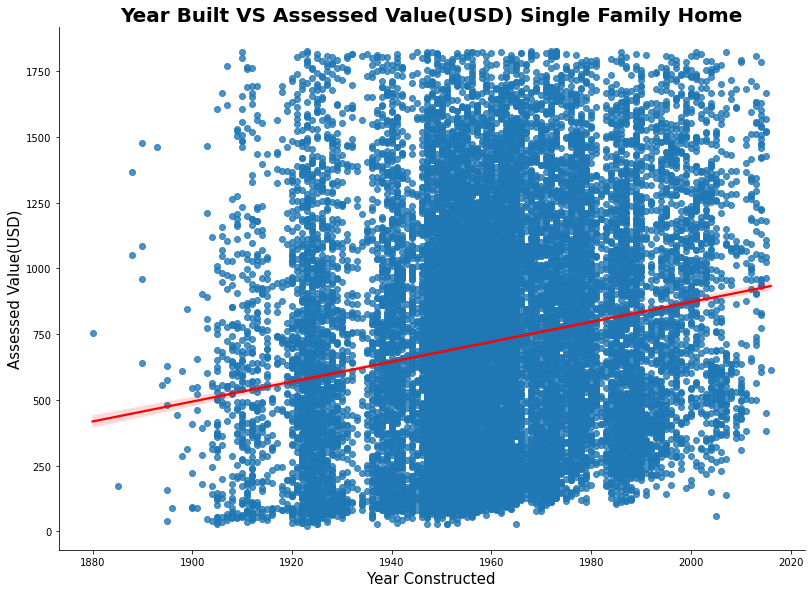

In [42]:
# Create lmplot showing regression
sns.lmplot(x="built_year", y="assessed_val_scaled", data = train, 
            height = 8, aspect = 11.7/8.27, line_kws={'color': 'red'})

plt.title('Year Built VS Assessed Value(USD) Single Family Home', color = 'black', weight = 'bold', size = 20)
plt.xlabel('Year Constructed', size = 15, color = 'black')
plt.ylabel('Assessed Value(USD)', size = 15, color = 'black')
plt.show()

##### Calculate the 'r' and 'p' values

In [43]:
# Formulated hypothesis
H0 = 'There is no correlation between a home\'s year built and and its variation in assessed value.'
H1 = 'A home\'s age is correlated to its variation in assessed value.'

# Use a scipy stats function pearsonr to calculate the correlation coefficient and the p-value.
r, p_value = spearmanr(train.built_year, train.assessed_value)

print('\nSPEARMANSR YEAR BUILT')

print(f'\n\t- Correlation Coefficient: {r}\n\n\t- P-value: {p_value}\n')


SPEARMANSR YEAR BUILT

	- Correlation Coefficient: 0.18517512549755133

	- P-value: 4.721513066750855e-167



##### Test the hypothesis

In [44]:
alpha = 0.05

if p_value > alpha:
    print(f"\nFAILED TO REJECT: {H0}\n")

else:
    print(f"\nREJECT: {H0}\n")


REJECT: There is no correlation between a home's year built and and its variation in assessed value.



## Summry: Top 3 Drivers for Assessed Value

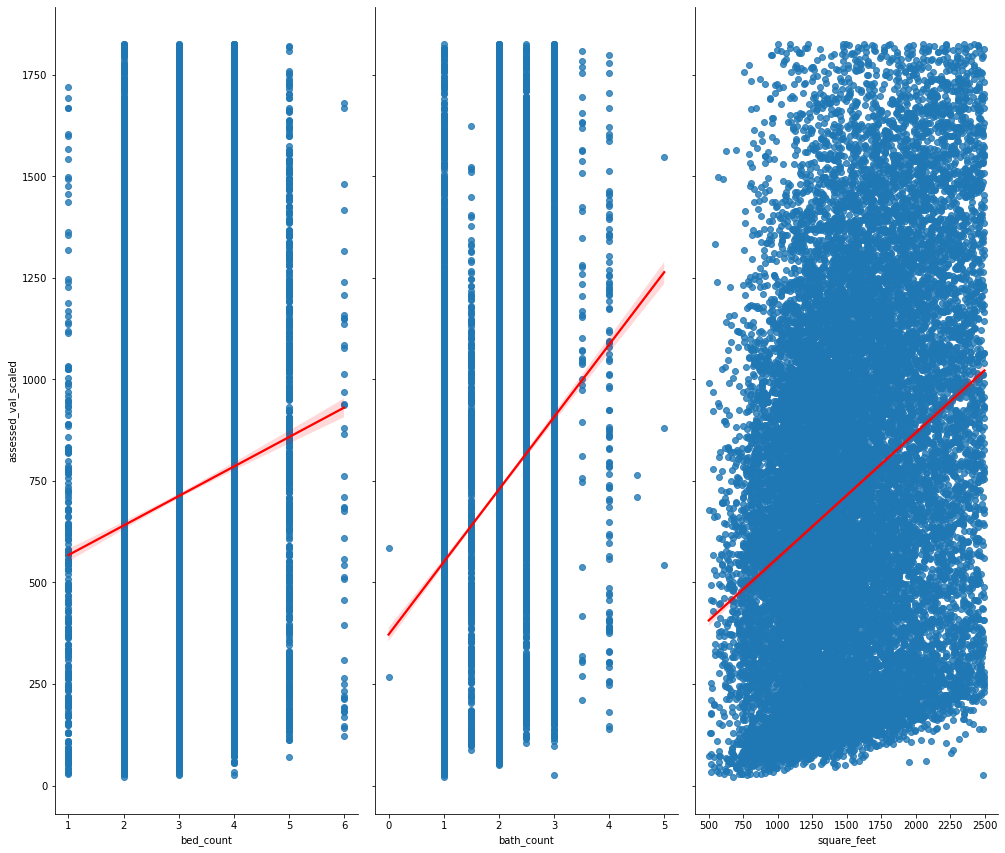

In [45]:
g = sns.pairplot(train, kind='reg', plot_kws={'line_kws':{'color':'red'}}, x_vars = ['bed_count', 'bath_count', 'square_feet'], 
                 y_vars = ['assessed_val_scaled'])

g.fig.set_size_inches(15,15)

## Summary: Other Factors Relations to Assessed Value

>- ### Examine Built / Age relations to assessed value. Shows increased linear regression suggesting its a driver

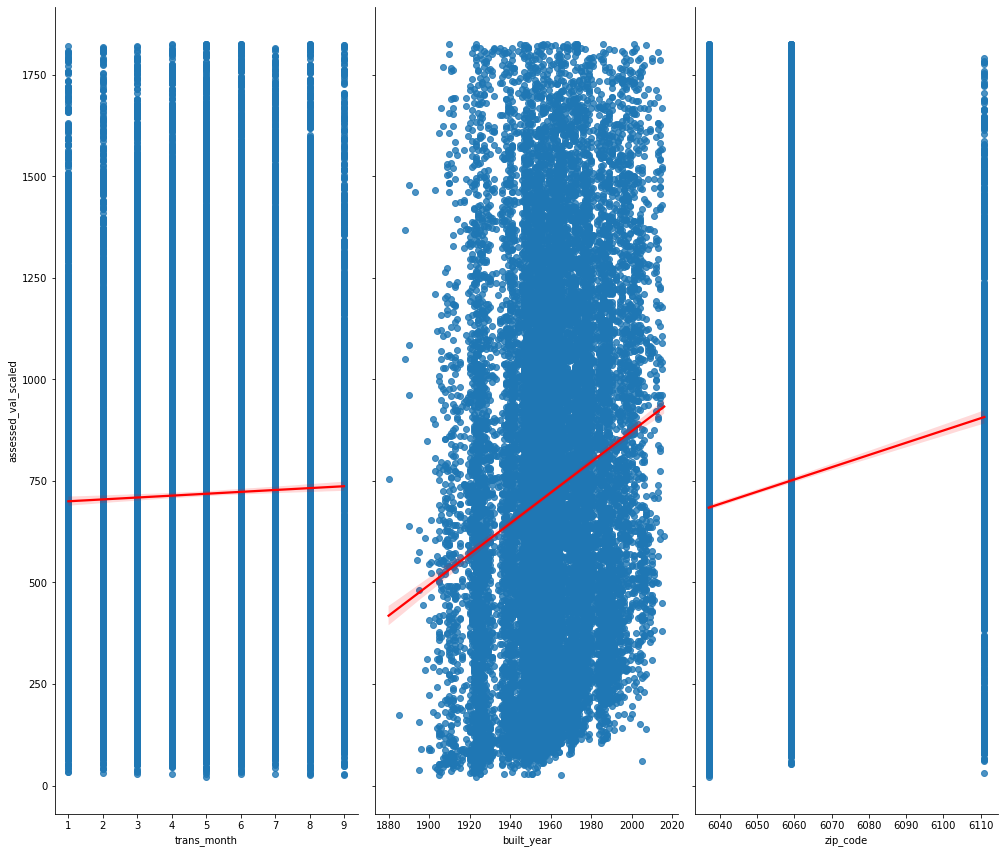

In [46]:
g = sns.pairplot(train, kind='reg', plot_kws={'line_kws':{'color':'red'}}, x_vars = ['trans_month', 'built_year', 'zip_code'], 
                 y_vars = ['assessed_val_scaled'])

g.fig.set_size_inches(15,15)

# <u>Correlations Calculations:</u> 

### Zillow Correlation 

In [77]:
train.head()

,bed_count,bath_count,square_feet,assessed_value,trans_month,trans_day,built_year,zip_code,city,home_age,square_feet_scaled,age_scaled,assessed_val_scaled,bed_scaled,bath_scaled
52025,4.0,2.5,2273.0,632472.0,9,14,1996,6059,Orange,52,1.735931,-3.346465,1443.843361,-3.456305,-3.459738
44995,3.0,1.0,1087.0,220726.0,8,9,1951,6037,Los Angeles,52,-0.978037,-3.346465,501.629924,-3.458593,-3.463170
5788,4.0,2.0,1901.0,378909.0,2,10,1938,6037,Los Angeles,52,0.884669,-3.346465,863.605870,-3.456305,-3.460882
5772,2.0,1.0,1200.0,46969.0,2,10,1965,6037,Los Angeles,52,-0.719455,-3.346465,104.015423,-3.460882,-3.463170
11140,1.0,2.0,988.0,415256.0,3,16,1962,6037,Los Angeles,52,-1.204582,-3.346465,946.780040,-3.463170,-3.460882


In [80]:
zillow_corr = train.drop(columns = ['city','trans_day', 'zip_code','built_year', 
                                    'trans_month', 'zip_code', 'home_age','square_feet_scaled',
                                    'age_scaled', 'assessed_val_scaled','bed_scaled','bath_scaled']).corr()


### Correlation Heatmap Matrix

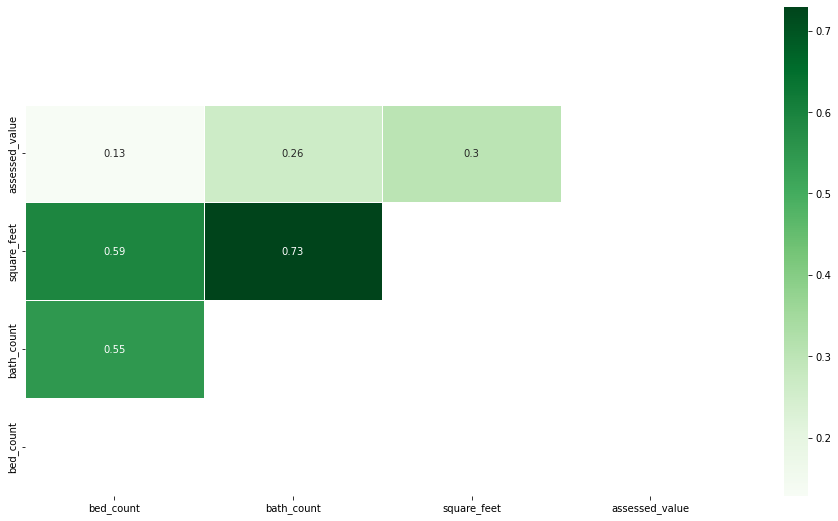

In [79]:
plt.figure(figsize=(16,9))
sns.heatmap(zillow_corr, cmap='Greens', annot=True, linewidth=0.5, mask= np.triu(zillow_corr))
plt.ylim(0, 5)

plt.show()

### Correlation Coefficient (Pearsonr - Constant linear relationship)

In [82]:
# Use a scipy stats function pearsonr to calculate the correlation coefficient and the p-value.

r, p_value = pearsonr(train.square_feet, train.assessed_value)
print('\nPEARSONR')

print(f'\n\t- Correlation Coefficient: {r}\n\n\t- P-value: {p_value}\n')



PEARSONR

	- Correlation Coefficient: 0.30438153045943933

	- P-value: 0.0



### With Spearman (Normally Distributed Data)

In [83]:
# Spearman (Normally distributed

zillow_spearman = train.drop(columns=['city','trans_day', 'zip_code','built_year', 
                                    'trans_month', 'zip_code', 'home_age','square_feet_scaled',
                                    'age_scaled', 'assessed_val_scaled','bed_scaled','bath_scaled']).corr(method='spearman')
zillow_spearman


,bed_count,bath_count,square_feet,assessed_value
bed_count,1.000000,0.546268,0.590021,0.129102
bath_count,0.546268,1.000000,0.739430,0.274831
square_feet,0.590021,0.739430,1.000000,0.292677
assessed_value,0.129102,0.274831,0.292677,1.000000


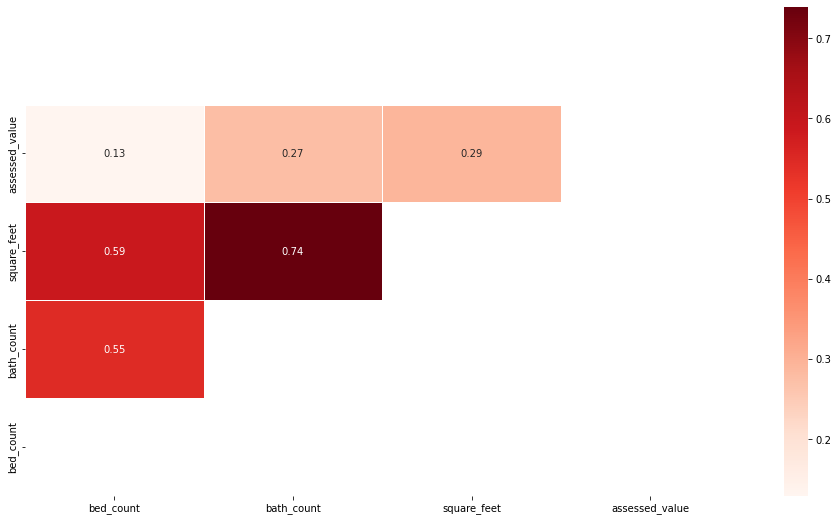

In [84]:
plt.figure(figsize=(16,9))

sns.heatmap(zillow_spearman, cmap='Reds', annot = True, linewidth=0.5, mask= np.triu(zillow_corr))

plt.ylim(0, 5)

plt.show()


# <u>Feature Engineering</u>

>#### Finding features that better represent the underlying problem to the predictive models, resulting in improved model accuracy on unseen data.

In [86]:
train.head()

,bed_count,bath_count,square_feet,assessed_value,trans_month,trans_day,built_year,zip_code,city,home_age,square_feet_scaled,age_scaled,assessed_val_scaled,bed_scaled,bath_scaled
52025,4.0,2.5,2273.0,632472.0,9,14,1996,6059,Orange,52,1.735931,-3.346465,1443.843361,-3.456305,-3.459738
44995,3.0,1.0,1087.0,220726.0,8,9,1951,6037,Los Angeles,52,-0.978037,-3.346465,501.629924,-3.458593,-3.463170
5788,4.0,2.0,1901.0,378909.0,2,10,1938,6037,Los Angeles,52,0.884669,-3.346465,863.605870,-3.456305,-3.460882
5772,2.0,1.0,1200.0,46969.0,2,10,1965,6037,Los Angeles,52,-0.719455,-3.346465,104.015423,-3.460882,-3.463170
11140,1.0,2.0,988.0,415256.0,3,16,1962,6037,Los Angeles,52,-1.204582,-3.346465,946.780040,-3.463170,-3.460882


In [85]:
# Select features to explore 

X_train = train[['bed_count', 'bath_count', 'square_feet',
                 'trans_month', 'trans_day', 'built_year', 'zip_code']]
y_train = train.assessed_value

X_validate = validate[['bed_count', 'bath_count', 'square_feet', 
                       'trans_month', 'trans_day', 'built_year', 'zip_code']]
y_validate = validate.assessed_value

X_test = test[['bed_count', 'bath_count', 'square_feet', 
               'trans_month', 'trans_day', 'built_year', 'zip_code']]
y_test = test.assessed_value

## (1). SelectKBest

In [54]:
select_k_best = select_kbest_feature_engineering(X_train, y_train, 3)
select_k_best

Enter count of SelectKBest features to return: 5


Index(['bed_count', 'bath_count', 'square_feet', 'built_year', 'zip_code'], dtype='object')

>### Rank SelectKBest Features

In [55]:
kbest = SelectKBest(f_regression, k = 2)

kbest.fit(X_train, y_train)

SelectKBest(k=2, score_func=<function f_regression at 0x7fa0154ac160>)

In [56]:
kbest_results = pd.DataFrame(dict(p = kbest.pvalues_, 
                                  f = kbest.scores_), 
                             index = X_train.columns)
kbest_results

,p,f
bed_count,6.345328e-81,366.026063
bath_count,0.000000e+00,1611.035492
square_feet,0.000000e+00,2220.854511
trans_month,2.649507e-04,13.307595
trans_day,2.211694e-02,5.237313
built_year,4.490966e-151,696.321767
zip_code,1.734211e-97,443.531479


In [57]:

X_train_transformed = pd.DataFrame(kbest.transform(X_train),index = X_train.index,
                                   columns = X_train.columns[kbest.get_support()])


X_train_transformed.head()


,bath_count,square_feet
52025,2.5,2273.0
44995,1.0,1087.0
5788,2.0,1901.0
5772,1.0,1200.0
11140,2.0,988.0


## (2). Recursive Feature Elimination (RFE)

In [58]:
rfe_feature_engineering(X_train, y_train, 3)

Enter count of RFE features to return: 5


Index(['bed_count', 'bath_count', 'trans_month', 'trans_day', 'zip_code'], dtype='object')

>### Rank RFE Features

In [59]:
# Call linear reg'
model = LinearRegression()

# Fit the model and select best two features (n_features_to_select = 2)
rfe = RFE(model, n_features_to_select = 2)
rfe.fit(X_train, y_train)

# Rank the RFE features
pd.DataFrame({'rfe_ranks': rfe.ranking_}, index = X_train.columns)

,rfe_ranks
bed_count,1
bath_count,1
square_feet,5
trans_month,2
trans_day,4
built_year,6
zip_code,3


In [60]:
# RFE Ranking
X_train_transformed = pd.DataFrame(rfe.transform(X_train),index = X_train.index,
                                   columns = X_train.columns[rfe.support_])

X_train_transformed.head()

,bed_count,bath_count
52025,4.0,2.5
44995,3.0,1.0
5788,4.0,2.0
5772,2.0,1.0
11140,1.0,2.0


# <u>Exploration Summary</u>

- The features evaluated in this datasets are:
 - Squre feet
 - Number of beds a home has
 - Number of bath counts
 - The month transaction was conducted
 - The Location of the property by zip-code

### (i). SelectKBest Feature Results:

 - ### [ 'bed_count', 'bath_count', 'square_feet' ]


### (ii). RFE Feature Results:
 - ### ['bed_count', 'bath_count', 'built_year']

### (iii). Overall Ranking
 - ### ['bed_count', 'bath_count', 'square_feet', 'trans_month', 'trans_day', 'built_year', 'zip_code']

## <u>Observations</u>

- ##### Note correlation do not tell the complete story of data. It measures linear relationship between 2 variables. This project approach is to compare two relationship individually and check effects on assessed value of homes in 2017.
- __Heat map:__ 
  - Sqaure feet -> 0.6
  - Bath count -> 0.51
  - Bed count -> 0.27
 
- __SpearmanR:__
  - Sqaure feet -> 0.53
  - Bath count -> 0.49
  - Bed count -> 0.3
  
- ##### The heatmap summary and SpearmanR summary above shows that square feet is the leading feature contributing to assessed value for 2017 Zillow properties. 
- ##### With alpha level of 0.05, all independeny features tested resulted in reject in null hypothesis. __Meaning,__ there are correlation between above features with assessed value. 




# Moving forward... 
## Since square feet is the leading driver for assessed value, we will build a model with this feature to predict assessed home value for single household family home in 2017. 


>- ## If time permits:
>- #### Year built effect on assessed value
>- #### Effects of Location
>- #### Square feet and bath count 84%


# <u>Modeling Phase: </u>

### Models choosen: 

-       Linear Regression
    
-        Polynomial Regression
    
-        Tweedie Regression (GLM)



Steps: 
    
    Predict all assessed values
    
    Computer RMSE
    
    
    

## Models: 1st Iteration:
#### Features: ['bed_count', 'bath_count', 'square_feet']

In [111]:
# Select features to explore 

X_train = train[['bed_count', 'bath_count', 'square_feet']]
y_train = train.assessed_value

X_validate = validate[['bed_count', 'bath_count', 'square_feet']]
y_validate = validate.assessed_value

X_test = test[['bed_count', 'bath_count', 'square_feet']]
y_test = test.assessed_value

In [112]:
# # Select features to explore 

# X_train = train[['bed_scaled', 'bed_scaled', 'square_feet_scaled']]
# y_train = train.assessed_value

# X_validate = validate[['bed_scaled', 'bed_scaled', 'square_feet_scaled']]
# y_validate = validate.assessed_value

# X_test = test[['bed_scaled', 'bed_scaled', 'square_feet_scaled']]
# y_test = test.assessed_value

>### Create Baseline

In [113]:
# We need y_train and y_validate to be dataframes to append the new columns with predicted values. 
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

# 1. Predict asssessed_values_pred_mean
asssessed_value_pred_mean = y_train['assessed_value'].mean()
y_train['asssessed_value_pred_mean'] = asssessed_value_pred_mean
y_validate['asssessed_value_pred_mean'] = asssessed_value_pred_mean

# 2. compute asssessed_values_pred_median
asssessed_value_pred_median = y_train['assessed_value'].median()
y_train['asssessed_value_pred_median'] = asssessed_value_pred_median
y_validate['asssessed_value_pred_median'] = asssessed_value_pred_median

# 3. RMSE of asssessed_values_pred_mean
rmse_train = mean_squared_error(y_train.assessed_value, y_train.asssessed_value_pred_mean)**(1/2)
rmse_validate = mean_squared_error(y_validate.assessed_value, y_validate.asssessed_value_pred_mean)**(1/2)

print("\nRMSE USING MEAN #1\n\tTrain/In-Sample:", round(rmse_train, 2),
      "\n\tValidate/Out-of-Sample: ", round(rmse_validate, 2))

# 4. RMSE of asssessed_values_pred_median
rmse_train = mean_squared_error(y_train.assessed_value, y_train.asssessed_value_pred_median)**(1/2)
rmse_validate = mean_squared_error(y_validate.assessed_value, y_validate.asssessed_value_pred_median)**(1/2)

print("\n\nRMSE USING MEDIAN #1\n\tTrain/In-Sample: ", round(rmse_train, 2), 
      "\n\tValidate/Out-of-Sample: ", round(rmse_validate, 2))
print()


RMSE USING MEAN #1
	Train/In-Sample: 193231.11 
	Validate/Out-of-Sample:  193416.03


RMSE USING MEDIAN #1
	Train/In-Sample:  194294.19 
	Validate/Out-of-Sample:  194651.93



>### Actual VS Predicted  Assessed Values

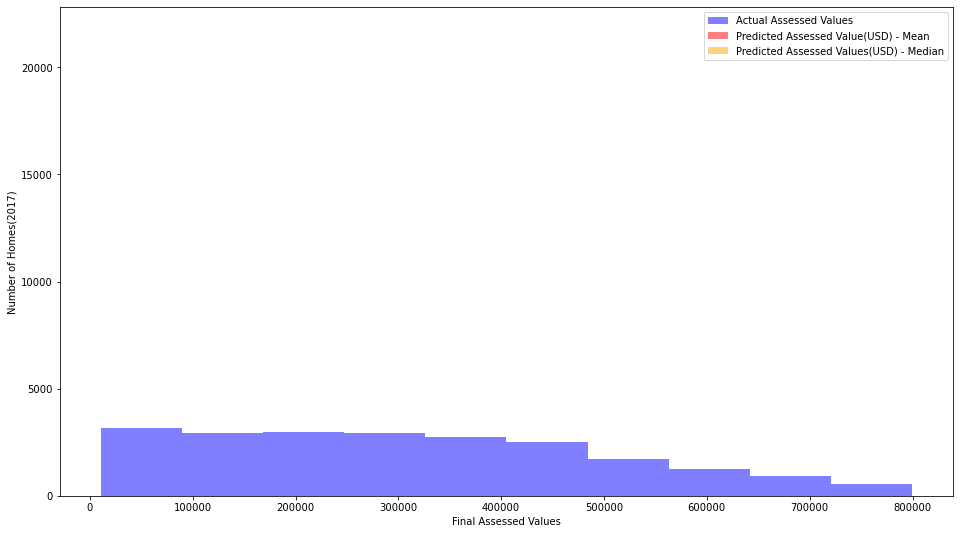

In [114]:
# Plot to visualize actual vs predicted. 

plt.figure(figsize=(16, 9))

plt.hist(y_train.assessed_value, color='blue', alpha=.5, label="Actual Assessed Values")

plt.hist(y_train.asssessed_value_pred_mean, bins=1, color='red', alpha=.5, rwidth=100, label="Predicted Assessed Value(USD) - Mean")

plt.hist(y_train.asssessed_value_pred_median, bins=1, color='orange', alpha=.5, rwidth=100, label="Predicted Assessed Values(USD) - Median")

plt.xlabel("Final Assessed Values")

plt.ylabel("Number of Homes(2017)")

plt.legend()

plt.show()


## (A). Linear Regression (OLS) (Model I)

Steps:

    1). Fit the model using X_train & labels from y_train
    
    2). Predict final assessed value for homes in training sample using our model(lm)
    
    3). Evaluate model using RMSE
    
    4). Repeat predictions & evaluate for validation
    
    5). Compare RMSE train VS validation. Overfitting?



In [115]:
# create the model object
lm = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm.fit(X_train, y_train.assessed_value)

# predict train
y_train['assessed_val_pred_lm'] = lm.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.assessed_value, y_train.assessed_val_pred_lm)**(1/2)

# predict validate
y_validate['assessed_val_pred_lm'] = lm.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.assessed_value, y_validate.assessed_val_pred_lm)**(1/2)
print()
print("RMSE FOR OLS USING LINEAR-REGRESSION(Bed, bath & Square Feet) #1:\n\n\tTraining/In-Sample: ", rmse_train, 
      "\n\n\tValidation/Out-of-Sample: ", rmse_validate)
print()


RMSE FOR OLS USING LINEAR-REGRESSION(Bed, bath & Square Feet) #1:

	Training/In-Sample:  183077.00964762436 

	Validation/Out-of-Sample:  183293.08873430008



## (B). Polynomial Regression (Model I)

Steps: 

    1). Create the new features, based on value indicated for degree for train, validate & test.

    2). Fit the Linear Regression model

    3). Predict using the transformed (squared or cubed, e.g.) features

    4). Evaluate using RMSE

    5). Repeat predictions and evaluation for validation.

    6). Compare RMSE train vs. validation. Overfitting?

>##### Create polynomial features first

In [116]:
# Make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2)

# fit and transform X_train_scaled
X_train_degree2 = pf.fit_transform(X_train)

# transform X_validate_scaled & X_test_scaled
X_validate_degree2 = pf.transform(X_validate)
X_test_degree2 = pf.transform(X_test)


> ##### Create Linear Regression object & Model

In [117]:
# create the model object
lm2 = LinearRegression(normalize = True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm2.fit(X_train_degree2, y_train.assessed_value)

# predict train
y_train['assessed_val_pred_lm2'] = lm2.predict(X_train_degree2)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.assessed_value, y_train.assessed_val_pred_lm2)**(1/2)

# predict validate
y_validate['assessed_val_pred_lm2'] = lm2.predict(X_validate_degree2)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.assessed_value, y_validate.assessed_val_pred_lm2)**(1/2)

print("\nRMSE FOR POLYNOMIAL MODEL: (degrees = 2) #1:\n\n\tTraining/In-Sample: ", rmse_train, 
      "\n\n\tValidation/Out-of-Sample: ", rmse_validate)



RMSE FOR POLYNOMIAL MODEL: (degrees = 2) #1:

	Training/In-Sample:  182939.87430309935 

	Validation/Out-of-Sample:  183306.67148609337


# (C). TweedieRegressor (GLM) (Model I)

##### The most flexible regression algorithm, the GLM allows for different distributions, beyond just the Normal Distribution for OLS (and other models based on OLS, like LASSO). 


Steps:

    1). Fit the model using X_train and the labels from y_train.

    2). Predict final grade for students in training sample using our model (glm).

    3). Evaluate using RMSE

    4). Repeat predictions and evaluation for validation.

    5). Compare RMSE train vs. validation. Overfitting?

In [165]:
# create the model object
glm = TweedieRegressor(power = 1, alpha = 0)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
glm.fit(X_train, y_train.assessed_value)

# predict train
y_train['assessed_val_pred_glm'] = glm.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.assessed_value, y_train.assessed_val_pred_glm)**(1/2)

# predict validate
y_validate['assessed_val_pred_glm'] = glm.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.assessed_value, y_validate.assessed_val_pred_glm)**(1/2)

print("\nRMSE FOR GLM USING TWEEDIE: (power = 1 & alpha = 0) #1\n\n\tTraining/In-Sample: ", rmse_train, 
      "\n\n\tValidation/Out-of-Sample: ", rmse_validate)



RMSE FOR GLM USING TWEEDIE: (power = 1 & alpha = 0) #1

	Training/In-Sample:  193231.1086789722 

	Validation/Out-of-Sample:  193416.02876853055


In [166]:
train.columns

Index(['bed_count', 'bath_count', 'square_feet', 'assessed_value',
       'trans_month', 'trans_day', 'built_year', 'zip_code', 'city',
       'home_age', 'square_feet_scaled', 'age_scaled', 'assessed_val_scaled',
       'bed_scaled', 'bath_scaled'],
      dtype='object')

# Models: 2nd Iteration:  
## Features: ['square_feet',  'built_year', 'zip_code']

In [173]:
# Select features to explore 

X_train2 = train[['square_feet', 'built_year', 'zip_code', 'bed_count', 'bath_count', 
                  'square_feet','age_scaled','trans_month','bed_scaled','bath_scaled' ]]
y_train2 = train.assessed_value

X_validate2 = validate[['square_feet',  'built_year', 'zip_code', 'bed_count', 'bath_count', 'square_feet','age_scaled','trans_month','bed_scaled','bath_scaled' ]]
y_validate2 = validate.assessed_value

X_test2 = test[['square_feet',  'built_year', 'zip_code', 'bed_count', 'bath_count', 'square_feet','age_scaled','trans_month','bed_scaled','bath_scaled' ]]
y_test2 = test.assessed_value

#### Create baseline 

In [174]:
# We need y_train and y_validate to be dataframes to append the new columns with predicted values. 
y_train2 = pd.DataFrame(y_train2)
y_validate2 = pd.DataFrame(y_validate2)

# 1. Predict asssessed_values_pred_mean
asssessed_value_pred_mean = y_train['assessed_value'].mean()
y_train2['asssessed_value_pred_mean'] = asssessed_value_pred_mean
y_validate2['asssessed_value_pred_mean'] = asssessed_value_pred_mean

# 2. compute asssessed_values_pred_median
asssessed_value_pred_median = y_train['assessed_value'].median()
y_train2['asssessed_value_pred_median'] = asssessed_value_pred_median
y_validate2['asssessed_value_pred_median'] = asssessed_value_pred_median

# 3. RMSE of asssessed_values_pred_mean
rmse_train2 = mean_squared_error(y_train2.assessed_value, y_train2.asssessed_value_pred_mean)**(1/2)
rmse_validate2 = mean_squared_error(y_validate2.assessed_value, y_validate2.asssessed_value_pred_mean)**(1/2)

print("\nRMSE USING MEAN #2\n\n\tTrain/In-Sample:", round(rmse_train2, 2),
      "\n\n\tValidate/Out-of-Sample: ", round(rmse_validate2, 2))

# 4. RMSE of asssessed_values_pred_median
rmse_train2 = mean_squared_error(y_train2.assessed_value, y_train2.asssessed_value_pred_median)**(1/2)
rmse_validate2 = mean_squared_error(y_validate2.assessed_value, y_validate2.asssessed_value_pred_median)**(1/2)

print("\n\nRMSE USING MEDIAN #2\n\n\tTrain/In-Sample: ", round(rmse_train2, 2), 
      "\n\n\tValidate/Out-of-Sample: ", round(rmse_validate2, 2))
print()


RMSE USING MEAN #2

	Train/In-Sample: 193231.11 

	Validate/Out-of-Sample:  193416.03


RMSE USING MEDIAN #2

	Train/In-Sample:  194294.19 

	Validate/Out-of-Sample:  194651.93




# (A2).  Linear Regression (OLS) (Model II)


In [175]:
# create the model object
lm2_2 = LinearRegression(normalize = True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm2_2.fit(X_train2, y_train2.assessed_value)

# predict train
y_train2['assessed_val_pred_lm_2'] = lm2_2.predict(X_train2)

# evaluate: rmse
rmse_train2_2 = mean_squared_error(y_train2.assessed_value, y_train2.assessed_val_pred_lm_2)**(1/2)

# predict validate
y_validate2['assessed_val_pred_lm_2'] = lm2_2.predict(X_validate2)

# evaluate: rmse
rmse_validate2_2 = mean_squared_error(y_validate2.assessed_value, y_validate2.assessed_val_pred_lm_2)**(1/2)
print()
print("RMSE FOR OLS USING LINEAR-REGRESSION #2[Bed, bath & Square Feet]:\n\n\tTraining/In-Sample: ", rmse_train2_2, 
      "\n\n\tValidation/Out-of-Sample: ", rmse_validate2_2)
print()


RMSE FOR OLS USING LINEAR-REGRESSION #2[Bed, bath & Square Feet]:

	Training/In-Sample:  186690.6686691326 

	Validation/Out-of-Sample:  186779.2787839188



# (B2).  Polynomial Regression (Model II):


>##### Create Polynomial Features First


In [176]:
# Make the polynomial features to get a new set of features
pf2 = PolynomialFeatures(degree = 2)

# fit and transform X_train_scaled
X_train_degree2_2 = pf2.fit_transform(X_train2)

# transform X_validate_scaled & X_test_scaled
X_validate_degree2_2 = pf2.transform(X_validate2)
X_test_degree2_2 = pf2.transform(X_test2)


> ##### Create Linear Regression object & Model

In [171]:
# create the model object
lm2_2 = LinearRegression(normalize = True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm2_2.fit(X_train_degree2_2, y_train2.assessed_value)

# predict train
y_train2['assessed_val_pred_lm2_2'] = lm2_2.predict(X_train_degree2_2)

# evaluate: rmse
rmse_train_2 = mean_squared_error(y_train2.assessed_value, y_train2.assessed_val_pred_lm2_2)**(1/2)

# predict validate
y_validate2['assessed_val_pred_lm2_2'] = lm2_2.predict(X_validate_degree2_2)

# evaluate: rmse
rmse_validate_2 = mean_squared_error(y_validate2.assessed_value, y_validate2.assessed_val_pred_lm2_2)**(1/2)

print("\nRMSE FOR POLYNOMIAL MODEL #2: (degrees = 2):\n\n\tTraining/In-Sample: ", rmse_train_2, 
      "\n\n\tValidation/Out-of-Sample: ", rmse_validate_2)


RMSE FOR POLYNOMIAL MODEL #2: (degrees = 2):

	Training/In-Sample:  179730.544802755 

	Validation/Out-of-Sample:  179644.09009727373


In [178]:
y_test2 = pd.DataFrame(y_test2)

# predict on test
y_test2['assessed_val_pred_lm2_2'] = lm2_2.predict(X_test2)

# evaluate: rmse
rmse_test2 = mean_squared_error(y_test2.assessed_value, y_test2.assessed_val_pred_lm2_2)**(1/2)

print("\n\tRMSE for OLS Model using LinearRegression\n\tOut-of-Sample Performance: ", rmse_test2)
print()


	RMSE for OLS Model using LinearRegression
	Out-of-Sample Performance:  186430.66860502952



# (C2). TweedieRegressor (GLM) (Model II)


The most flexible regression algorithm, the GLM allows for different distributions, beyond just the Normal Distribution for OLS (and other models based on OLS, like LASSO)


- power = 0: Normal Distribution

- power = 1: Poisson Distribution

- power = (1,2): Compound Distribution

- power = 2: Gamma Distribution

- power = 3: Inverse Gaussian Distribution

In [135]:
# create the model object
glm2 = TweedieRegressor(power = 1, alpha = 0)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
glm2.fit(X_train2, y_train2.assessed_value)

# predict train
y_train2['assessed_val_pred_glm2'] = glm2.predict(X_train2)

# evaluate: rmse
rmse_train2 = mean_squared_error(y_train2.assessed_value, y_train2.assessed_val_pred_glm2)**(1/2)

# predict validate
y_validate2['assessed_val_pred_glm2'] = glm.predict(X_validate2)

# evaluate: rmse
rmse_validate2 = mean_squared_error(y_validate2.assessed_value, y_validate2.assessed_val_pred_glm2)**(1/2)

print("\nRMSE FOR GLM USING TWEEDIE: (power = 1 & alpha = 0) #2\n\n\tTraining/In-Sample: ", rmse_train2, 
      "\n\n\tValidation/Out-of-Sample: ", rmse_validate2)




RMSE FOR GLM USING TWEEDIE: (power = 1 & alpha = 0) #2

	Training/In-Sample:  193231.1086789722 

	Validation/Out-of-Sample:  193416.02876853055


# Evaluate The Models:

>## Visualizations

>> ## Model I - Actual vs Predicted Value 

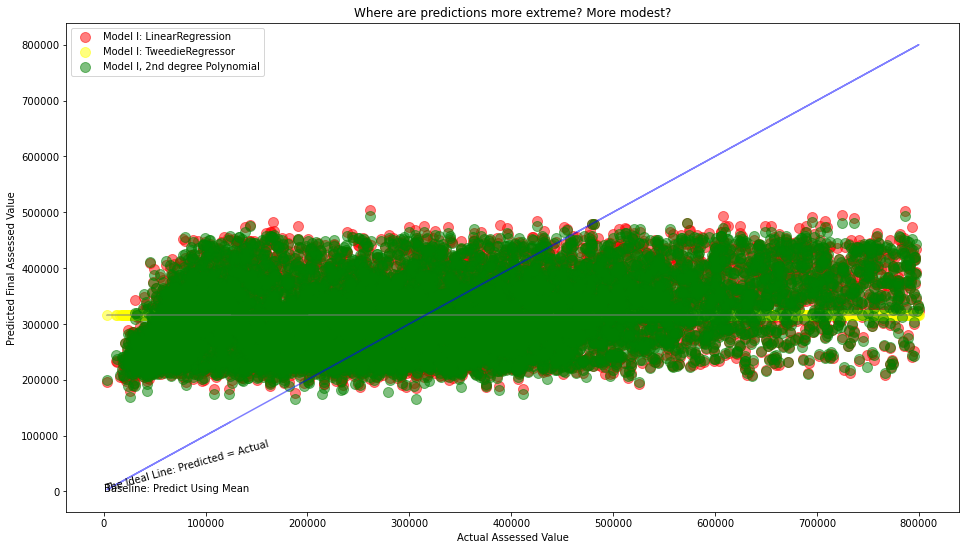

In [136]:
# y_validate.head()
plt.figure(figsize=(16,9))

plt.plot(y_validate.assessed_value, y_validate.asssessed_value_pred_mean, alpha=.5, color="gray", label='_nolegend_')

plt.annotate("Baseline: Predict Using Mean", (16, 9.5))

plt.plot(y_validate.assessed_value, y_validate.assessed_value, alpha=.5, color="blue", label='_nolegend_')

plt.annotate("The Ideal Line: Predicted = Actual", (.5, 3.5), rotation=15.5)

plt.scatter(y_validate.assessed_value, y_validate.assessed_val_pred_lm, 
            alpha=.5, color="red", s=100, label="Model I: LinearRegression")

plt.scatter(y_validate.assessed_value, y_validate.assessed_val_pred_glm, 
            alpha=.5, color="yellow", s=100, label="Model I: TweedieRegressor")

plt.scatter(y_validate.assessed_value, y_validate.assessed_val_pred_lm2, 
            alpha=.5, color="green", s=100, label="Model I, 2nd degree Polynomial")

plt.legend()
plt.xlabel("Actual Assessed Value")
plt.ylabel("Predicted Final Assessed Value")
plt.title("Where are predictions more extreme? More modest?")
# plt.annotate("The polynomial model appears to overreact to noise", (2.0, -10))
# plt.annotate("The OLS model (LinearRegression)\n appears to be most consistent", (15.5, 3))
plt.show()


>>## Model II: - Actual VS Predicted Values

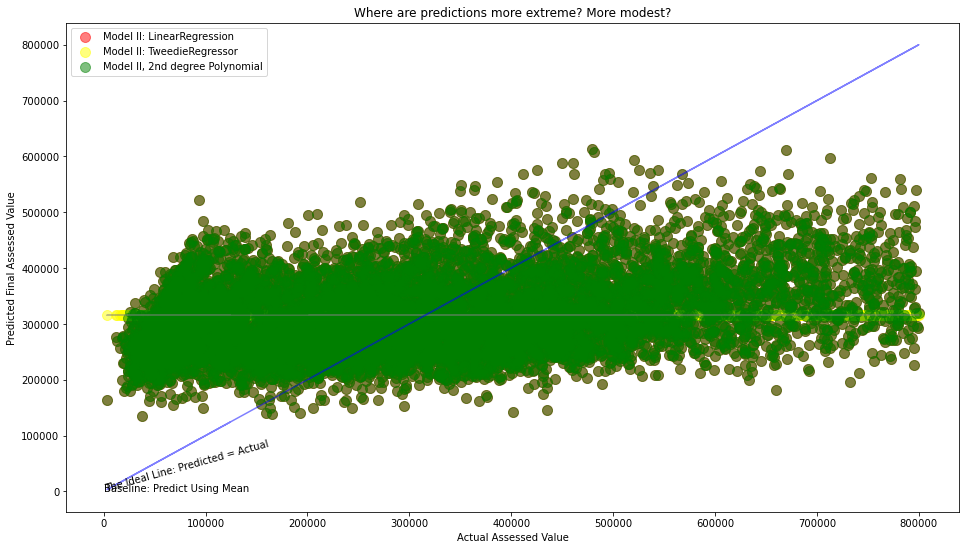

In [128]:
# y_validate.head()
plt.figure(figsize=(16,9))

plt.plot(y_validate2.assessed_value, y_validate2.asssessed_value_pred_mean, alpha=.5, color="gray", label='_nolegend_')

plt.annotate("Baseline: Predict Using Mean", (16, 9.5))

plt.plot(y_validate2.assessed_value, y_validate2.assessed_value, alpha=.5, color="blue", label='_nolegend_')

plt.annotate("The Ideal Line: Predicted = Actual", (.5, 3.5), rotation=15.5)

plt.scatter(y_validate2.assessed_value, y_validate2.assessed_val_pred_lm2_2, 
            alpha=.5, color="red", s=100, label="Model II: LinearRegression")

plt.scatter(y_validate2.assessed_value, y_validate2.assessed_val_pred_glm2, 
            alpha=.5, color="yellow", s=100, label="Model II: TweedieRegressor")

plt.scatter(y_validate2.assessed_value, y_validate2.assessed_val_pred_lm2_2, 
            alpha=.5, color="green", s=100, label="Model II, 2nd degree Polynomial")

plt.legend()
plt.xlabel("Actual Assessed Value")
plt.ylabel("Predicted Final Assessed Value")
plt.title("Where are predictions more extreme? More modest?")
# plt.annotate("The polynomial model appears to overreact to noise", (2.0, -10))
# plt.annotate("The OLS model (LinearRegression)\n appears to be most consistent", (15.5, 3))
plt.show()



## Residual Plots

>## Model I: Errors in Predictions 

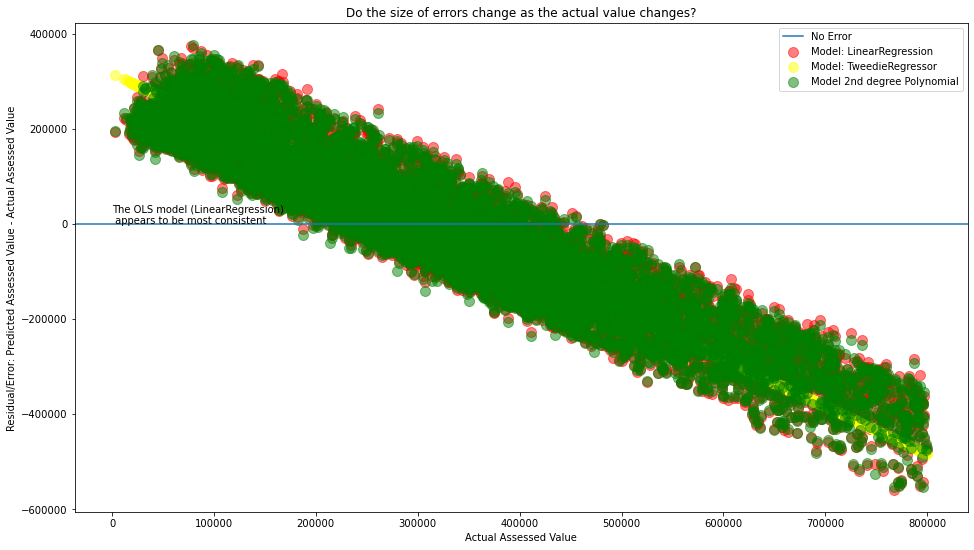

In [129]:
# y_validate.head()
plt.figure(figsize=(16,9))
plt.axhline(label="No Error")

plt.scatter(y_validate.assessed_value, y_validate.assessed_val_pred_lm - y_validate.assessed_value, 
            alpha=.5, color="red", s=100, label="Model: LinearRegression")

plt.scatter(y_validate.assessed_value, y_validate.assessed_val_pred_glm - y_validate.assessed_value, 
            alpha=.5, color="yellow", s=100, label="Model: TweedieRegressor")

plt.scatter(y_validate.assessed_value, y_validate.assessed_val_pred_lm2 - y_validate.assessed_value, 
            alpha=.5, color="green", s=100, label="Model 2nd degree Polynomial")

plt.legend()

plt.xlabel("Actual Assessed Value")

plt.ylabel("Residual/Error: Predicted Assessed Value - Actual Assessed Value")

plt.title("Do the size of errors change as the actual value changes?")

# plt.annotate("The polynomial model appears to overreact to noise", (2.0, -10))

plt.annotate("The OLS model (LinearRegression)\n appears to be most consistent", (15.5, 3))

plt.show()


In [130]:
y_validate.head()

,assessed_value,asssessed_value_pred_mean,asssessed_value_pred_median,assessed_val_pred_lm,assessed_val_pred_lm2,assessed_val_pred_glm
45420,201720.0,315589.601186,295292.5,410035.514079,417079.114746,315589.601186
47673,260195.0,315589.601186,295292.5,295100.206309,299125.485316,315589.601186
11912,117573.0,315589.601186,295292.5,299958.766542,302335.499359,315589.601186
47520,420000.0,315589.601186,295292.5,238925.984439,243143.263311,315589.601186
7909,137274.0,315589.601186,295292.5,415027.266286,422527.407292,315589.601186


## Histograms

> ### Model I (Best Model)

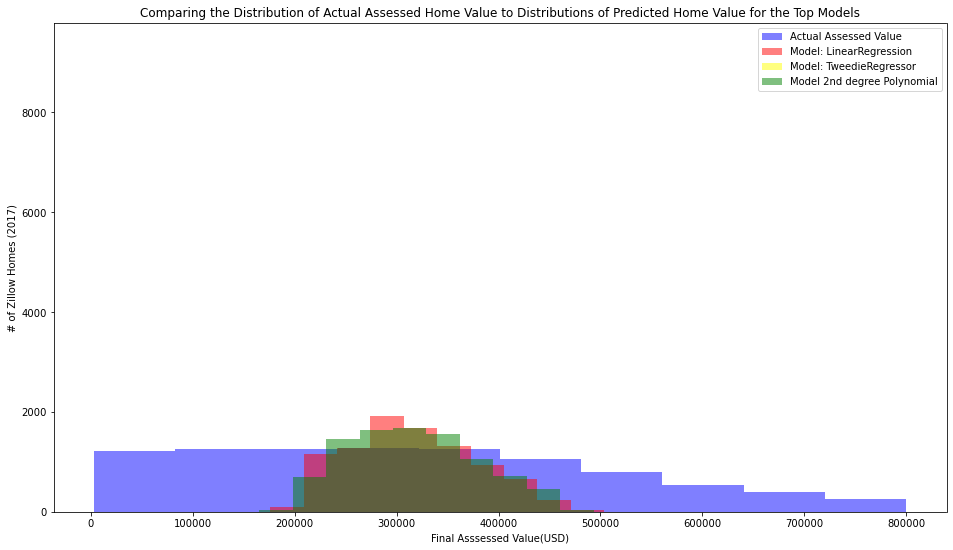

In [137]:
# plot to visualize actual vs predicted. 
plt.figure(figsize=(16,9))

plt.hist(y_validate.assessed_value, color='blue', alpha = .5, label="Actual Assessed Value")

plt.hist(y_validate.assessed_val_pred_lm, color='red', alpha=.5, label="Model: LinearRegression")

plt.hist(y_validate.assessed_val_pred_glm, color='yellow', alpha=.5, label="Model: TweedieRegressor")

plt.hist(y_validate.assessed_val_pred_lm2, color='green', alpha=.5, label="Model 2nd degree Polynomial")

plt.xlabel("Final Asssessed Value(USD)")

plt.ylabel("# of Zillow Homes (2017)")

plt.title("Comparing the Distribution of Actual Assessed Home Value to Distributions of Predicted Home Value for the Top Models")

plt.legend()

plt.show()


> ### Model II (Best Model)

In [ ]:
# plot to visualize actual vs predicted. 
plt.figure(figsize=(16,9))

plt.hist(y_validate.assessed_value, color='blue', alpha = .5, label="Actual Assessed Value")

plt.hist(y_validate.assessed_val_pred_lm2_2, color='red', alpha=.5, label="Model: LinearRegression")

plt.hist(y_validate.assessed_val_pred_glm2, color='yellow', alpha=.5, label="Model: TweedieRegressor")

plt.hist(y_validate.assessed_val_pred_lm2_2, color='green', alpha=.5, label="Model 2nd degree Polynomial")

plt.xlabel("Final Grade (G3)")

plt.ylabel("# of Zillow Homes (2017)")

plt.title("Comparing the Distribution of Actual Assessed Home Value to Distributions of Predicted Home Value for the Top Models")

plt.legend()

plt.show()

# Model Selection & Out of Sample Selection

In [141]:
# @nd Iteration Model selection 

y_test2 = pd.DataFrame(y_test)

# predict on test
y_test2['assessed_val_pred_lm2'] = lm2.predict(X_test2)

# evaluate: rmse
rmse_test2 = mean_squared_error(y_test2.assessed_value, y_test2.assessed_val_pred_lm2)**(1/2)

print("\n\tRMSE for OLS Model using LinearRegression\n\tOut-of-Sample Performance: ", rmse_test2)
print()

ValueError: X has 3 features, but LinearRegression is expecting 10 features as input.

# Conclusions and Delivery: 

## Establish Baseline

In [ ]:
# Create two-dimentional array with assigned column names

zillow_main_feature = pd.DataFrame(np.array(train[['square_feet', 'assessed_value']].to_numpy()), columns = ['square_feet', 'assessed_value'])
zillow_main_feature.head(3)


#### Create the yhat feature

In [ ]:
zillow_main_feature['yhat_baseline'] = zillow_main_feature['assessed_value'].mean()
zillow_main_feature.head()

In [ ]:
# # Map X, and y to features of interest and check lenght

# X = zillow_main_driver_feature['square_feet']
# y = zillow_main_driver_feature['assessed_value']

In [ ]:
# assessed_value_regression_plot(zillow_main_driver_feature, X, y)

## Build the Model

In [ ]:
# Import the required library
from sklearn.linear_model import LinearRegression
from math import sqrt

# Create the model
model = LinearRegression()

# Fit the model 
model.fit(zillow_main_feature[['square_feet']], zillow_main_feature.assessed_value)

# compute predictions and add to original dataframe
zillow_main_feature['yhat_predicted'] = model.predict(zillow_main_feature[['square_feet']])

zillow_main_feature.head(3)

# How good is our Model Results?

## Calculate Metrics (Model & Baseline) 

> ### (i). Sum of Squared Errors (SSE) 

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score

# SSE Model
SSE_model1 = mean_squared_error(zillow_main_feature.assessed_value, zillow_main_feature.yhat_predicted) * len(zillow_main_feature)

# SSE Baseline 
SSE_baseline1 = mean_squared_error(zillow_main_feature.assessed_value, zillow_main_feature.yhat_baseline) * len(zillow_main_feature)


print(f'\n\tSSE Baseline: {SSE_baseline1:,} \n\n\tSSE Model: {SSE_model1:,}\n')



> ### (ii). Explained Sum of Squares (ESS)

In [ ]:
# ESS Model 
ESS_model1 = sum(zillow_main_feature.yhat_predicted - zillow_main_feature.assessed_value.mean() ** 2)

# ESS Baseline
ESS_baseline1 = sum(zillow_main_feature.yhat_baseline - zillow_main_feature.assessed_value.mean() ** 2)

print(f'\n\tESS Baseline: {ESS_baseline1:,} \n\n\tESS Model: {ESS_model1:,}\n')


> ### (iii). Total Sum of Squares (TSS)

In [ ]:
# TSS Model 
TSS_model1 = (ESS_model1 + SSE_model1)

# TSS Baseline
TSS_baseline1 = (ESS_baseline1 + SSE_baseline1)

print(f'\n\tTSS Baseline: {TSS_baseline1:,} \n\n\tTSS Model: {TSS_model1:,}\n')


 > ### (iv). Mean Squared Error  (MSE)

In [ ]:
# MSE Model 
MSE_model1 = mean_squared_error(zillow_main_feature.assessed_value, zillow_main_feature.yhat_predicted)

# MSE Baseline
MSE_baseline1 = mean_squared_error(zillow_main_feature.assessed_value, zillow_main_feature.yhat_baseline)

print(f'\n\tMSE Baseline: {MSE_baseline1:,} \n\n\tMSE Model: {MSE_model1:,}\n')


> ### (v). Root Mean Squared Error (RMSE)

In [ ]:
# RMSE Model
RMSE_model1 = sqrt(mean_squared_error(zillow_main_feature.assessed_value, zillow_main_feature.yhat_predicted))

# RMSE Baseline
RMSE_baseline1 = sqrt(mean_squared_error(zillow_main_feature.assessed_value, zillow_main_feature.yhat_baseline))

print(f'\n\tRMSE Baseline: {RMSE_baseline1:,} \n\n\tRMSE Model: {RMSE_model1:,}\n')


## Baseline Vs Modeled Predictions Summary

> #### __NOTE:__ (Lower values is the better prediction)

In [ ]:
# Comprehensive with all the calculations

baseline = pd.DataFrame(np.array(['SSE_baseline1', 'MSE_baseline1', 'RMSE_baseline1']), columns=['BASELINE PREDICTIONS:'])
modeled_prediction = pd.DataFrame(np.array(['SSE_model1', 'MSE_model1', 'RMSE_model1']), columns=['MODEL PREDICTIONS:'])

baseline['Baseline_Error'] = np.array([SSE_baseline1, MSE_baseline1, RMSE_baseline1])
modeled_prediction['Model_Error'] = np.array([SSE_model1, MSE_model1, RMSE_model1])


print(f'{baseline}\n\n {modeled_prediction}')

## Variance as Inferred from Model (Model Error - Baseline Error)

In [ ]:
modeled_prediction['(Model_Error-Baseline Error)'] = (modeled_prediction.Model_Error - baseline.Baseline_Error)

modeled_prediction

## Model Selection & Testing

In [ ]:
x = zillow_main_feature['square_feet']
y = zillow_main_feature['assessed_value']

yhat = zillow_main_feature.yhat_predicted

baseline_vs_model_regression(zillow_main_feature, x, y, yhat)

# Model Evaluations

### Is my model better than my baseline predictions?

>- ### Our model performs better than our baseline model as shown by the Root Mean Squared Error (RMSE) below:

>-  #####  MODEL RMSE = 5.729700e+05
>-  #####  BASELINE RMSE = 7.157777e+05

>- ### However, how strong is this model dependent on the driver? Lets determine __Coefficient of Determination (R^2)__ to test this significance. 

R2 tells you how well your model fits the data by measuring the strength of the relationship between your model and the dependent variable. However, it is not a formal test for the relationship. The F-test of overall significance is the hypothesis test for this relationship. It indicates whether your linear regression model provides a better fit to the data than a model that contains no independent variables.

If the overall F-test is significant (evident through the p-value of the F statistic), you can conclude that 
R2 does not equal zero, and the correlation between the model and dependent variable is statistically significant.


### Calculate Strength of Dependent Variable to Model



In [ ]:
# sklearn.metrics.explained_variance_score

evs = explained_variance_score(zillow_main_feature.assessed_value, zillow_main_feature.yhat_predicted)
print('Explained Variance (R^2) = ', round(evs,3))
